In [1]:
import cv2
import SUNRGBD
import random as rand
import pandas as pd
import numpy as np
import json
import os
import shutil
import sys
import h5py
import scipy.io

In [2]:
path_to_sun = "../../SUNRGBD/"

In [3]:
%pwd

'/home/orneke/planercnn/sun'

In [4]:
store = []
for f in os.listdir(path_to_sun):
    if not f.startswith('.'):
        store.append(f)
        
b = []
for i in range(len(store)):
    for f in os.listdir(path_to_sun + store[i]):
        if not f.startswith('.'):
            b.append(path_to_sun + store[i] + "/" + f + "/")
store = []

c = []
for i in range(len(b)):
    if b[i] != (path_to_sun + "xtion/sun3ddata/"):
        for f in os.listdir(b[i]):
            if not f.startswith('.'):
                store.append(b[i]  + f + "/")
    else:
        for f in os.listdir(b[i]):
            if not f.startswith('.'):
                c.append(b[i]  + f + "/")

In [5]:
for i in range(len(c)):
    for f in os.listdir(c[i]):
        if not f.startswith('.'):
            for r in os.listdir(c[i]  + f + "/"):
                if not r.startswith('.'):
                    store.append(c[i]  + f + "/" + r + "/")


In [6]:
#just excluded
#'/Users/ekaterina/Desktop/diploma/mask_rcnn/datasets/SUNRGBD/kv2/kinect2data/000667_2014-06-09_21-06-12_260595134347_rgbf000145-resize/'
#checking that we collected all the pictures
len(store)

10335

In [7]:
#The standdard trainval-test split uses the first 5050 images for testing and the rest for trainval.
if not os.path.exists((path_to_sun + "test") or (path_to_sun + "train")):
    os.makedirs(path_to_sun + "test")
    os.makedirs(path_to_sun + "train")
if not os.path.exists((path_to_sun + "train" + "/train") or (path_to_sun + "train"+ "/val")):
    os.makedirs(path_to_sun + "train" + "/train")
    os.makedirs(path_to_sun + "train"+ "/val")

# Work with a class mapping

In [8]:
import pandas as pd
import scipy.io

mat = scipy.io.loadmat('classMapping40.mat')

label_13 = [1,2,3,4,5,6,7,8,9,10,11,12,13]
name_13 = ["bed", "books", "ceiling", 
                 "chair", "floor", "furniture", 
                 "objects", "picture", "sofa", 
                 "table", "tv", "wall", "window"]

labels_13 = pd.DataFrame({
     'label_13': label_13,
     'name_13': name_13})

In [9]:
list_of_40 = []
for i in range(0, len(mat["className"][0])):
    list_of_40.append(mat["className"][0][i][0]) 
    
label_of_40 = list(range(1,41))
merging = [12,5,6,1,4,9,10,12,13,6,8,6,13,10,6,13,6,7,7,5,7,3,2,6,11,7,7,7,7,7,7,6,7,7,7,7,7,7,6,7]

labels_40 = pd.DataFrame({
     'Label_40': label_of_40,
     'Name_40': list_of_40,
     "label_13": merging})

In [10]:
allClassName_894 = []
for i in range(0, len(mat["allClassName"][0])):
    allClassName_894.append(mat["allClassName"][0][i][0])

mapClass_894 = []
for i in range(0, len(mat["mapClass"][0])):
    mapClass_894.append(mat["mapClass"][0][i])
    
labels_894 = pd.DataFrame({
     'Label_40': list(mapClass_894),
     'Name_894': list(allClassName_894)})

In [11]:
df = pd.read_csv('name_mapping_from_toolbox')
df = df.drop(['Unnamed: 0'], axis=1)
df = pd.merge(df, labels_40, left_on="Label_37", right_on="Label_40").drop([ 'Label_37', 'Name_37'], axis=1)

In [12]:
print(labels_894.loc[labels_894['Name_894'] == 'book'])
df3 = pd.merge(labels_894, labels_40)
final_dataset = pd.merge(df3, labels_13)

   Label_40 Name_894
0        40     book


In [13]:
labels_needed = {}
#Converting data to work with 13 classes
for i in range(0, len(df)):
    labels_needed[str(df.iloc[i]['Name_6585'])] = df.iloc[i]['label_13']
    
# Adding data for the dun from matlab file
#Converting data to work with 13 classes
for i in range(0, len(final_dataset)):
    labels_needed[str(final_dataset.iloc[i]['Name_894'])] = final_dataset.iloc[i]['label_13']

# Start the parsing

In [14]:
all_labels = []
for key in labels_needed.keys():
    all_labels.append(key)

In [15]:
import stringdist

ufo = {}
def transformation(image_root, number_of_image):
    # Set the paths
    image_root = image_root
    path_to_image = image_root + "image/" + (os.listdir(image_root + "/image/")[0])
    anotation = image_root + 'annotation2Dfinal'
    
    with open(anotation + "/index.json") as data_file:
        data = json.load(data_file)
    
    numberOfAnot = len(data["frames"][0]["polygon"])
    element = {}

    size =  os.path.getsize(path_to_image)
    filename = os.listdir(image_root + "/image")
    filename = filename[0]

    element = {"fileref": '', "size": size, 
        "filename": str(number_of_image) + ".jpg", 'base64_img_data': '', 'file_attributes': {}, 'regions': {}}
    
    anootation2D = []
    labels2D = []
    regions = {}
    
    for i in range(0, numberOfAnot):
        x = data["frames"][0]["polygon"][i]["x"]
        y = data["frames"][0]["polygon"][i]["y"]
        idxObj = data["frames"][0]["polygon"][i]["object"]
        if idxObj <= len(data['objects']):
            label = data['objects'][idxObj]["name"].lower()
            label = ''.join(i for i in label if not i.isdigit())
            if label in labels_needed:
                label = labels_needed[label]
            else:
                leve = {}
                for i in range(0,len(all_labels)):
                    leve[all_labels[i]] = stringdist.levenshtein(label, all_labels[i])
                label = labels_needed[min(leve, key=leve.get)]
                ufo[min(leve, key=leve.get)] = label
            if type(x) == list and type(y) == list:
                all_points_x = list(map(round, x))
                all_points_y = list(map(round, y))
                if len(all_points_y) != 0 and len(all_points_x) != 0:
                    shape_attributes = {'name':'polygon',"all_points_x":x,"all_points_y":y}
                    region = {'shape_attributes': {'name': 'polygon',
                    'all_points_x': x, 'all_points_y': y}, 'region_attributes': {"class": int(label)}}  
                    element['regions'][str(i)] = region
    return element

In [16]:
# For the NYU dataset
# 80% of train images - 1160 pics (0, 1160)
   # 10% test - 145 pics (1160,1305)
   # 10: validation - 144 pics (1305, 1449)
# 20% of test images - 289

# 5050 test images store[0 : 5049]
# 5285 train-val images [5050 : 10334]
   # 4226 train images [5050:9275]
   # 1056 validation images [9276: 10333]
d = {}
fail = []
# Working with a test dataset - 5050 images
for i in range(5050, 9275):
    try:
        element2 = {}
        number_of_image = i
        #print(number_of_image)
        element2 = transformation(store[i], number_of_image)
    #except json.decoder.JSONDecodeError:
    except ValueError:
        print("Fuckup with " + store[i])
        fail.append(store[i])
    #print(element2)
    if element2:
        file_name = os.listdir(store[i] + "/image")[0]
        file_to_copy = store[i] + "image/" + file_name
        target_dir = path_to_sun + "train/train/"
        shutil.copyfile(file_to_copy, target_dir + str(i) + ".jpg")
        d[str(i) + ".jpg" + str(os.path.getsize(file_to_copy))] = element2

jsonname2 =  path_to_sun + "train/train/" + "via_region_data.json"
with open(jsonname2, 'w') as fp:
        json.dump(d, fp)

Fuckup with ../../SUNRGBD/realsense/sa/2014_10_24-20_40_16-1311000073/
Fuckup with ../../SUNRGBD/kv1/b3dodata/img_0174/
Fuckup with ../../SUNRGBD/kv1/b3dodata/img_0139/
Fuckup with ../../SUNRGBD/xtion/sun3ddata/harvard_conf_big/hv_conf_big_1/0003496-000117171936/
Fuckup with ../../SUNRGBD/xtion/sun3ddata/hotel_beijing/beijing_hotel_1/0000634-000021249144/
Fuckup with ../../SUNRGBD/xtion/sun3ddata/brown_cs_7/brown_cs7/0000004-000000105238/
Fuckup with ../../SUNRGBD/xtion/sun3ddata/home_md/home_md_scan4_2012_july_29/0003900-000466989990/
Fuckup with ../../SUNRGBD/xtion/sun3ddata/mit_26_100/classroom_26100_nov_2_2012_scan1_erika/0006997-000305722660/
Fuckup with ../../SUNRGBD/xtion/sun3ddata/home_ph_cz/ph_cz_1/0001900-000063646884/
Fuckup with ../../SUNRGBD/xtion/sun3ddata/mit_lab_16/lab_16_nov_2_2012_scan1_erika/0000094-000003787308/
Fuckup with ../../SUNRGBD/xtion/sun3ddata/mit_lab_16/lab_16_nov_2_2012_scan1_erika/0011684-000499388400/
Fuckup with ../../SUNRGBD/xtion/sun3ddata/mit_46_6l

In [17]:
print("Pictures failed:" + str(len(fail)))
print("Pictures parsed:" + str(len(d)))

Pictures failed:15
Pictures parsed:4210


In [ ]:
ufo

In [21]:
d2 = {}
fail2 = []
# Working with a train dataset - 4226 images
for i in range(0, 5049):
    try:
        element2 = {}
        number_of_image = i
        #print(number_of_image)
        element2 = transformation(store[i], number_of_image)
        #print(element2)
        if element2:
            file_name = os.listdir(store[i] + "/image")[0]
            file_to_copy = store[i] + "image/" + file_name
            target_dir = path_to_sun + "test/"
            shutil.copyfile(file_to_copy, target_dir + str(i) + ".jpg")
            d2[str(i) + ".jpg" + str(os.path.getsize(file_to_copy))] = element2
    #except json.decoder.JSONDecodeError:
    except ValueError:
        print("Fuckup with " + store[i])
        fail2.append(store[i])

jsonname2 =  path_to_sun + "test/" + "via_region_data.json"
with open(jsonname2, 'w') as fp:
        json.dump(d2, fp)

Fuckup with ../../SUNRGBD/kv2/kinect2data/000667_2014-06-09_21-06-12_260595134347_rgbf000145-resize/
Fuckup with ../../SUNRGBD/kv2/kinect2data/000504_2014-06-08_23-03-02_260595134347_rgbf000064-resize/
Fuckup with ../../SUNRGBD/kv2/kinect2data/002922_2014-06-26_15-43-16_094959634447_rgbf000089-resize/
Fuckup with ../../SUNRGBD/kv2/kinect2data/003054_2014-06-15_13-54-54_094959634447_rgbf000113-resize/
Fuckup with ../../SUNRGBD/kv2/kinect2data/000467_2014-06-09_19-35-24_260595134347_rgbf000188-resize/
Fuckup with ../../SUNRGBD/kv2/kinect2data/000424_2014-06-08_17-05-00_260595134347_rgbf000115-resize/
Fuckup with ../../SUNRGBD/kv2/kinect2data/003158_2014-05-12_11-32-40_094959634447_rgbf002887-resize/
Fuckup with ../../SUNRGBD/kv2/kinect2data/000631_2014-06-08_16-30-36_260595134347_rgbf000088-resize/
Fuckup with ../../SUNRGBD/kv2/kinect2data/000668_2014-06-09_21-07-12_260595134347_rgbf000161-resize/
Fuckup with ../../SUNRGBD/kv2/kinect2data/001177_2014-06-17_15-46-38_260595134347_rgbf00005

In [22]:
print("Pictures failed:" + str(len(fail2)))
print("Pictures parsed:" + str(len(d2)))

Pictures failed:21
Pictures parsed:5028


In [23]:
d3 = {}
fail3 = []
# Working with a train dataset - 4226 images
for i in range(9276, 10333):
    try:
        element2 = {}
        number_of_image = i
        #print(number_of_image)
        element2 = transformation(store[i], number_of_image)
    except json.decoder.JSONDecodeError:
        print("Fuckup with " + store[i])
        fail3.append(store[i])
    #print(element2)
    if element2:
        file_name = os.listdir(store[i] + "/image")[0]
        file_to_copy = store[i] + "image/" + file_name
        target_dir = path_to_sun + "train/val/"
        shutil.copyfile(file_to_copy, target_dir + str(i) + ".jpg")
        d3[str(i) + ".jpg" + str(os.path.getsize(file_to_copy))] = element2

jsonname2 =  path_to_sun + "train/val/" + "via_region_data.json"
with open(jsonname2, 'w') as fp:
        json.dump(d3, fp)

Fuckup with ../../SUNRGBD/xtion/sun3ddata/mit_dorm_mcc_flr1/dorm_mcc_flr1_oct_31_2012_scan1_erika/0001153-000051532234/
Fuckup with ../../SUNRGBD/xtion/sun3ddata/hotel_uc/scan2/0000311-000157225998/
Fuckup with ../../SUNRGBD/xtion/sun3ddata/brown_cs_5/brown_cs5/0000634-000021457030/
Fuckup with ../../SUNRGBD/xtion/sun3ddata/mit_dorm_mcc_wph/dorm_mcc_wph_oct_31_2012_scan1_erika/0005980-000266256626/


In [24]:
print("Pictures failed:" + str(len(fail3)))
print("Pictures parsed:" + str(len(d3)))

Pictures failed:4
Pictures parsed:1053


In [26]:
len(store)

10335

In [89]:
image_root = store[6029]

In [90]:
frameData = SUNRGBD.readFrame(image_root, True )

In [91]:
frameData.imgRGB.shape, frameData.imgRGB.dtype

((427, 561, 3), dtype('uint8'))

In [70]:
import matplotlib.pyplot as plt
imgRGBWithAnnotations = np.array(frameData.imgRGB, copy=True)

for i in range(0, len(frameData.annotation2D)):
    color = [rand.randint(0,255), rand.randint(0,255), rand.randint(0,255)]
    cv2.fillPoly(imgRGBWithAnnotations, [frameData.annotation2D[i]], color)
    
for i in range(0, len(frameData.annotation2D)):
    data = frameData.annotation2D[i];
    centroid = np.mean(data,axis=0)
    cv2.putText(imgRGBWithAnnotations, frameData.labels2D[i], (int(centroid[0]), int(centroid[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.7, [0,0,0],2)
    

In [71]:
data = frameData.annotation2D
data2 = frameData.labels2D

In [72]:
anotation2D = image_root + "/annotation2Dfinal/index.json"

with open(anotation2D) as data_file:    
    data = json.load(data_file)

    numberOfAnot = len(data["frames"][0]["polygon"]);
    anootation2D = [];
    labels2D = [];
    for i in range(0,numberOfAnot):
        x = data["frames"][0]["polygon"][i]["x"]
        y = data["frames"][0]["polygon"][i]["y"]

        idxObj = data["frames"][0]["polygon"][i]["object"];
        pts2 = np.array([x,y], np.int32)
        pts2 = np.transpose(pts2);
        anootation2D.append(pts2);
        labels2D.append(data['objects'][idxObj]["name"])

Depth data


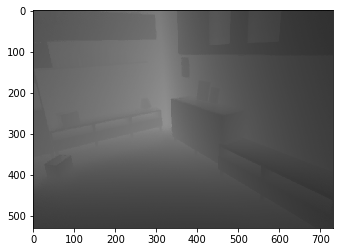

In [73]:
print("Depth data")
plt.imshow(frameData.imgD);

RGB Image


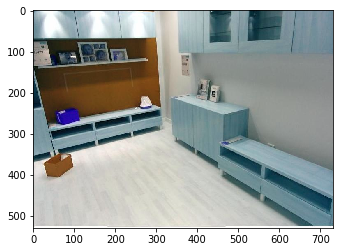

In [74]:
print("RGB Image")
plt.imshow(frameData.imgRGB);

Annotated Image


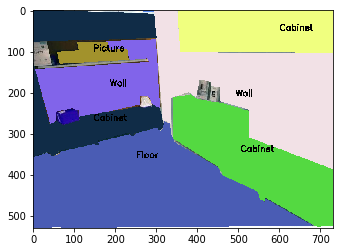

In [75]:
print("Annotated Image")
plt.imshow(imgRGBWithAnnotations);

((530, 730, 3), dtype('uint8'))

In [77]:
imgRGBWithAnnotations.shape

(530, 730, 3)

In [78]:
len(frameData.annotation2D)

9

In [57]:
frameData.annotation2D[0].shape, frameData.annotation2D[0].dtype

((36, 2), dtype('int32'))

In [ ]:
for i, p in enumerate(frameData.annotation2D):
    #print(p)
    x_coord = p[:,0]
    y_coord = p[:,1]
    for y in y_coord:
        if y > 730:
            print("y: ", y)
    for x in x_coord:
        if x > 530:
            print("x: ",x)

In [ ]:
for i, p in enumerate(dataset.image_info[img_id]["polygons"]):
    y_s = p['all_points_y']
    x_s = p['all_points_x']
    for y in y_s:
        if y > 730:
            print("y: ", y)
    for x in x_s:
        if x > 530:
            print("x: ",x)

In [64]:
frameData.annotation2D[0]

array([[833, 119],
       [757,  93],
       [707, 265],
       [833, 285]], dtype=int32)

In [67]:
frameData.annotation2D[0][:,1]

array([119,  93, 265, 285], dtype=int32)

In [72]:
len(frameData.annotation2D)

45

In [73]:
import skimage.draw


mask = np.zeros([530, 730, len(frameData.annotation2D)],
                        dtype=np.uint8)
rr, cc = skimage.draw.polygon(frameData.annotation2D[0][:,1], frameData.annotation2D[0][:,0])

print("r c: ",rr, cc)
mask[rr, cc, i] = 1

r c:  [ 94  94  94 ... 284 284 284] [757 758 759 ... 830 831 832]


IndexError: index 757 is out of bounds for axis 1 with size 730

In [130]:
masks = np.zeros([530, 730, 45])
for i in range(45):
    mask = np.zeros([530, 730])
    cv2.fillPoly(mask, [frameData.annotation2D[i]], 1)
    masks[:,:,i] = mask


In [114]:
frameData.annotation2D[3].shape

(13, 2)

In [113]:
frameData.annotation2D[1][0]

array([836,  85], dtype=int32)

In [127]:
mask.shape

(530, 730)

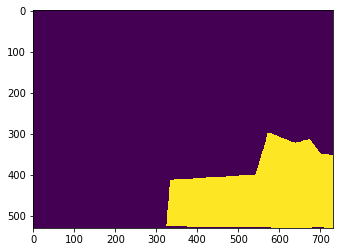

In [138]:
plt.imshow(masks[:,:,3])